# Face Generation
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and we're doing GANs in a project for the first time, we want we to test wer neural network on MNIST before CelebA.  Running the GANs on MNIST will allow we to see how well wer model trains sooner.

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As we're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. we can view the first number of examples by changing `show_n_images`. 

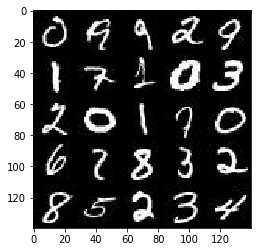

In [2]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  we can view the first number of examples by changing `show_n_images`.

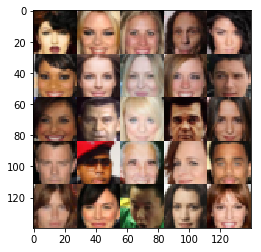

In [3]:
show_n_images = 25


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for we.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
we'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  we are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train wer neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="inputs_real") 
    
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="inputs_z")
    
    learning_rate = tf.placeholder(tf.float32, [])
    
    return inputs_real, inputs_z, learning_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Radford et al. : Use LeakyReLU activation in the discriminator for all layers
    # 2016             and don't apply batchnorm the discriminator input layer.
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        c1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha*c1, c1)
        # 14x14x64 now
        
        c2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x256 now
        
        c3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x512 now
        
        # flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits



tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Radford et al. : Use ReLU activation in generator for all layers except for the output, which uses Tanh
    # 2016             and don't apply batchnorm to the generator output layer
    
    reuse = not is_train
    alpha = 0.2
    
    
    with tf.variable_scope("generator", reuse=reuse):
        # Fully connected
        x1 = tf.layers.dense(z, 4*4*512)
        
        # reshape first, than normalize and activate (no leaky relu)
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #x1 = tf.nn.relu(x1)
        # 4x4x512 now

        
        # convolution 1
        c1 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding="valid")
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(alpha*c1, c1)
        #c1 = tf.nn.relu(c1)
        # 8x8x256 now

        
        # convolution 2
        c2 = tf.layers.conv2d_transpose(c1, 128, 4, strides=2, padding="same")
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.maximum(alpha*c2, c2)
        #c2 = tf.nn.relu(c2)
        
        # 16x16x128 now
        #print(c2.shape)    
        
        # c3
        c3 = tf.layers.conv2d_transpose(c2, out_channel_dim, 4, strides=2, padding="same")
        # 28 x 28 x out_channel_dim now (28x28x3)

        logits = c3
        #print(logits.shape)
        
        output = tf.tanh(logits)
    
    return output


tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions we implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_real) * 0.9,
                                                                         logits = d_logits_real))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(d_logits_real),
                                                                         logits = d_logits_fake))
    
    discriminator_loss = d_loss_real + d_loss_fake
    
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(d_logits_fake),
                                                                            logits = d_logits_fake))    
    
    return discriminator_loss, generator_loss



tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt



tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help we determine how well the GANs is training.

In [29]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions we implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while we train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: learning_rate})

                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    print("Step {}".format(steps))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[-1], data_image_mode)

                
                

### MNIST
Test wer GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 1.7611
Step 100


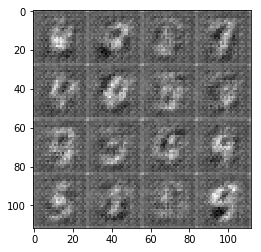

Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.5855
Step 200


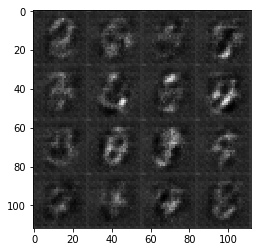

Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 1.5372
Step 300


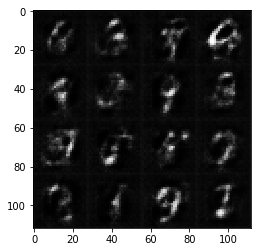

Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.2235
Step 400


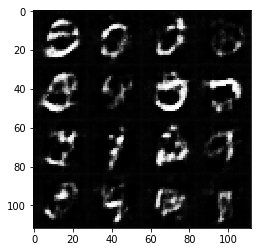

Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.5358
Step 500


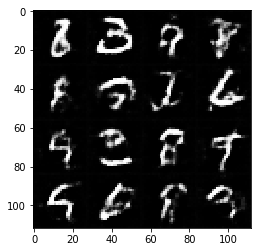

Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.6614
Step 600


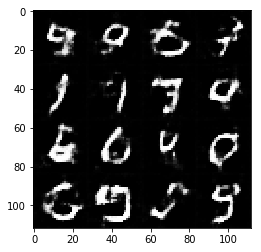

Epoch 2/2... Discriminator Loss: 1.7536... Generator Loss: 0.3138
Step 700


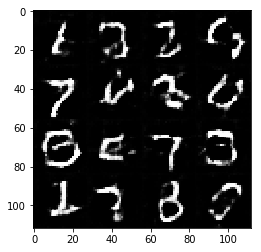

Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.0230
Step 800


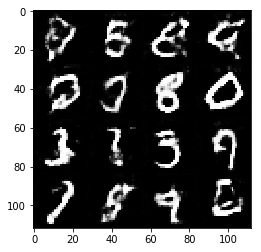

Epoch 2/2... Discriminator Loss: 1.6780... Generator Loss: 0.3620
Step 900


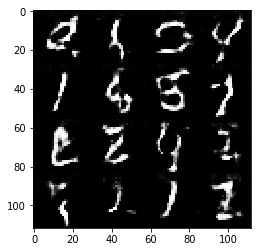

Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.4672
Step 1000


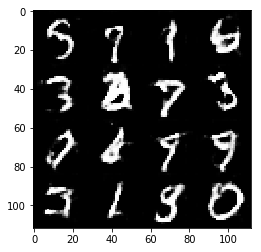

Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.5162
Step 1100


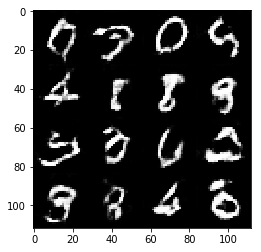

Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 0.9233
Step 1200


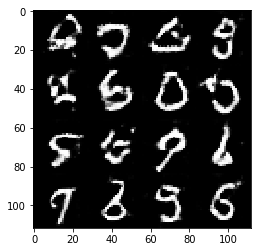

In [31]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run wer GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  we can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.2811
Step 100


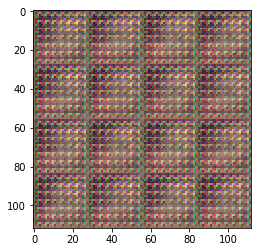

Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.5780
Step 200


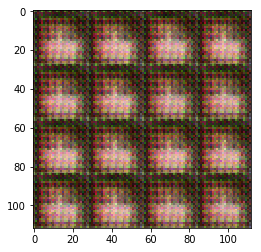

Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 3.1396
Step 300


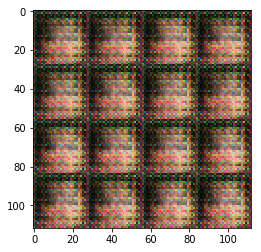

Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.5680
Step 400


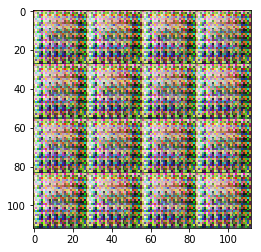

Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 3.1583
Step 500


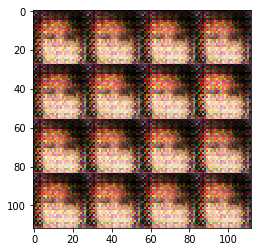

Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.9285
Step 600


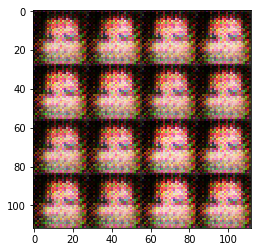

Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 1.8918
Step 700


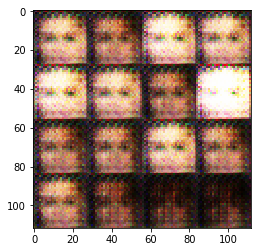

Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 2.1979
Step 800


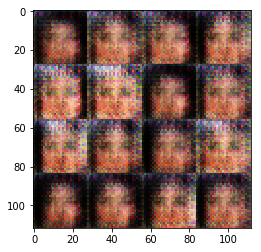

Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.5743
Step 900


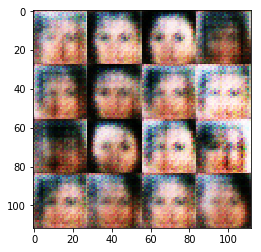

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.9048
Step 1000


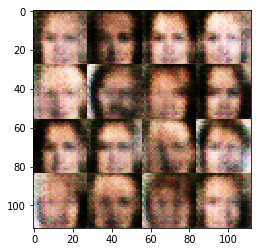

Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.2187
Step 1100


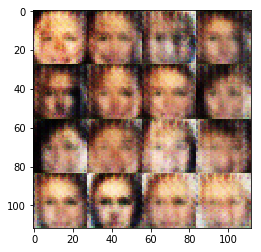

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.4781
Step 1200


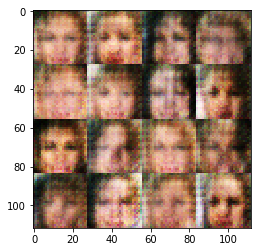

Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.0778
Step 1300


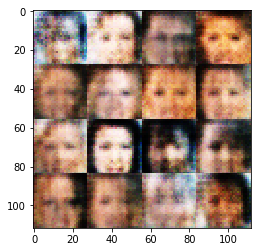

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9949
Step 1400


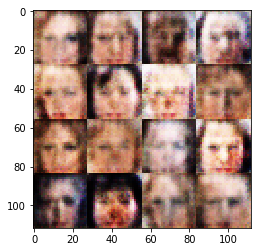

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.3702
Step 1500


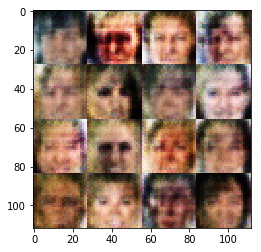

Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.4006
Step 1600


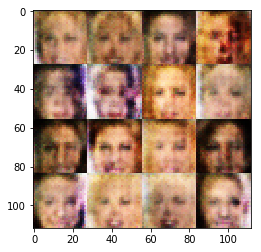

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9893
Step 1700


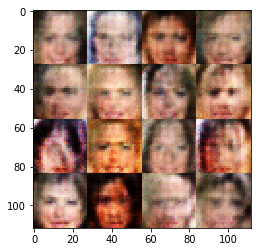

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.2289
Step 1800


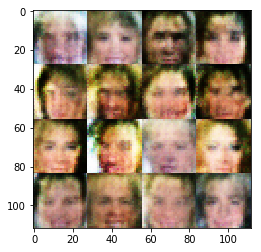

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.9350
Step 1900


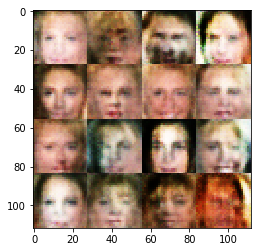

Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0998
Step 2000


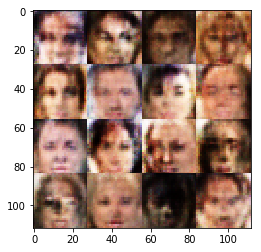

In [32]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)